In [1]:
# ============================================================================
# thermodynamics.py
# ============================================================================

import numpy as np
from typing import Tuple

# Physical constants
CP = 1005.0  # Specific heat at constant pressure [J/kg/K]
LV = 2.5e6  # Latent heat of vaporization [J/kg]
RV = 461.5  # Gas constant for water vapor [J/kg/K]
RD = 287.04  # Gas constant for dry air [J/kg/K]
G = 9.81  # Gravitational acceleration [m/s²]
EP = 0.622  # Ratio of molecular weights (dry air / water vapor)


def virtual_temperature(
    theta: np.ndarray, qt: np.ndarray, ql: np.ndarray
) -> np.ndarray:
    """
    Calculate virtual potential temperature

    Args:
        theta: Potential temperature [K]
        qt: Total specific humidity [kg/kg]
        ql: Liquid water mixing ratio [kg/kg]

    Returns:
        Virtual potential temperature [K]
    """
    return theta * (1.0 - (1.0 - RV / RD) * qt - RV / RD * ql)


def esat_liq(t: np.ndarray) -> np.ndarray:
    """Calculate saturation vapor pressure over liquid water [Pa]"""
    Tc = t - 273.15
    Tc = np.minimum(Tc, 50)  # Avoid excess values
    return 611.21 * np.exp(17.502 * Tc / (240.97 + Tc))


def qsat_liq(p: np.ndarray, t: np.ndarray) -> np.ndarray:
    """Calculate saturation specific humidity over liquid water [kg/kg]"""
    return EP * esat_liq(t) / (p - (1.0 - EP) * esat_liq(t))


def dqsatdT_liq(p: np.ndarray, t: np.ndarray) -> np.ndarray:
    """Calculate derivative of saturation specific humidity with respect to temperature"""
    den = p - esat_liq(t) * (1.0 - EP)
    return (
        (EP / den + (1.0 - EP) * EP * esat_liq(t) / den**2)
        * LV
        * esat_liq(t)
        / (RV * t**2)
    )


def calc_thetav(thl: float, qt: float, p: float, exner: float) -> Tuple[float, float]:
    """
    Calculate virtual potential temperature with saturation adjustment

    Args:
        thl: Liquid water potential temperature [K]
        qt: Total specific humidity [kg/kg]
        p: Pressure [Pa]
        exner: Exner function [-]

    Returns:
        (virtual potential temperature [K], saturation specific humidity [kg/kg])
    """
    tl = exner * thl
    qsat = qsat_liq(p, tl)

    if qt - qsat <= 0.0:
        return virtual_temperature(thl, qt, 0.0), qsat

    # Newton-Raphson iteration for saturation adjustment
    niter = 0
    nitermax = 100
    tnr = tl
    tnr_old = 1e9

    while (np.abs(tnr - tnr_old) / tnr_old > 1e-5) and (niter < nitermax):
        niter += 1
        tnr_old = tnr
        qsat = qsat_liq(p, tnr)
        f = tnr - tl - LV / CP * (qt - qsat)
        f_prime = 1 + LV / CP * dqsatdT_liq(p, tnr)
        tnr -= f / f_prime

    ql = qt - qsat
    return virtual_temperature(tnr / exner, qt, ql), qsat

In [2]:
# ============================================================================
# profiles.py
# ============================================================================

from dataclasses import dataclass
from typing import List
import numpy as np
# from thermodynamics import virtual_temperature, RD, CP, G


@dataclass
class ClassOutput:
    """Relevant variables from Class output."""

    h: float  # Boundary layer height [m]
    theta: float  # Potential temperature in boundary layer [K]
    dtheta: float  # Jump at top of boundary layer [K]
    dqt: float  # Jump at top of boundary layer [kg/kg]
    qt: float  # Total specific humidity in boundary layer [kg/kg]
    du: float  # Jump at top of boundary layer [m/s]
    u: float  # U-component in boundary layer [m/s]
    dv: float  # Jump at top of boundary layer [m/s]
    v: float  # V-component in boundary layer [m/s]



@dataclass
class ClassInput:
    """Input parameters from CLASS config"""
    # TODO: add p0 to class config
    p0: float  # Surface pressure [Pa]

    # Piecewise potential temperature profile
    z_theta: List[float]  # Heights of segment boundaries [m]
    gamma_theta: List[float]  # Temperature lapse rates in each segment [K/m]

    # Piecewise specific humidity profile
    z_qt: List[float]  # Heights of segment boundaries [m]
    gamma_qt: List[float]  # Humidity lapse rates in each segment [1/m]

    # Piecewise wind profiles
    z_u: List[float]  # Heights of segment boundaries [m]
    gamma_u: List[float]  # U-wind lapse rates in each segment [1/s]

    z_v: List[float]  # Heights of segment boundaries [m]
    gamma_v: List[float]  # V-wind lapse rates in each segment [1/s]


@dataclass
class AtmosphericProfile:
    """Atmospheric vertical profiles"""

    z: np.ndarray  # Height levels (cell centers) [m]
    theta: np.ndarray  # Potential temperature [K]
    qt: np.ndarray  # Total specific humidity [kg/kg]
    u: np.ndarray  # U-component of wind [m/s]
    v: np.ndarray  # V-component of wind [m/s]
    thetav: np.ndarray  # Virtual potential temperature [K]
    p: np.ndarray  # Pressure [Pa]
    exner: np.ndarray  # Exner function [-]
    T: np.ndarray  # Temperature [K]
    rho: np.ndarray  # Density [kg/m³]


def _piecewise_profile(
    z: np.ndarray,
    h: float,
    ml_value: float,
    jump: float,
    z_segments: List[float],
    gamma_segments: List[float],
) -> np.ndarray:
    """
    Create CLASS-style piecewise profile: mixed layer + inversion + free troposphere

    Args:
        z: Height array [m]
        h: Mixed-layer height [m]
        ml_value: Value in mixed layer (mixed layer)
        jump: Jump at mixed layer top (inversion)
        z_segments: Heights defining free troposphere segments [m]
        gamma_segments: Lapse rates in free troposphere segments [unit/m]

    Returns:
        Profile values at height levels z
    """
    profile = np.zeros_like(z)

    for i, _z in enumerate(z):
        if _z <= h:
            # Mixed layer: constant value
            profile[i] = ml_value
        else:
            # Above boundary layer: start with jump, then apply lapse rates
            current_value = ml_value + jump
            anchor_point = h

            # Find which segment this height falls into
            for seg_idx, z_top in enumerate(z_segments):
                if z_top < h:
                    # Mixed layer has grown beyond this segment; irrelevant
                    continue
                if _z >= z_top:
                    # We've passed this segment; add its contribution and update anchor
                    dz = z_top - anchor_point
                    current_value += gamma_segments[seg_idx] * dz
                    anchor_point = z_top
                else:
                    # Height falls within this segment
                    dz = _z - anchor_point
                    current_value += gamma_segments[seg_idx] * dz
                    break
            else:
                # Extend profile with last value of lapse rate
                # Shouldn't be needed, but can't enforce equal heights of segments in form
                dz = _z - z_top
                current_value += gamma_segments[seg_idx] * dz

            profile[i] = current_value

    return profile


def generate_profiles(
    config: ClassInput, output: ClassOutput, dz=1
) -> AtmosphericProfile:
    """
    Generate vertical atmospheric profiles from CLASS output

    Args:
        class_config: CLASS model configuration (subset)
        class_output: CLASS model output (subset)
        dz: grid spacing

    Returns:
        AtmosphericProfile with all computed variables
    """
    # z_top should be the same for all variables, but this is not guaranteed!
    z_top = config.z_theta[-1]

    # Generate height arrays (cell centers only)
    z = np.arange(0 + dz / 2, z_top, dz)

    # Generate half-levels for pressure calculation
    zh = np.arange(0, z_top + dz / 2, dz)

    # Calculate piecewise profiles
    theta = _piecewise_profile(
        z, output.h, output.theta, output.dtheta, config.z_theta, config.gamma_theta
    )

    qt = _piecewise_profile(
        z, output.h, output.qt, output.dqt, config.z_qt, config.gamma_qt
    )

    u = _piecewise_profile(z, output.h, output.u, output.du, config.z_u, config.gamma_u)

    v = _piecewise_profile(z, output.h, output.v, output.dv, config.z_v, config.gamma_v)

    # Calculate virtual potential temperature (assuming dry base state)
    thetav = virtual_temperature(theta, qt, np.zeros_like(qt))

    # For pressure calculation, we need profiles on half-levels
    thetah = _piecewise_profile(
        zh, output.h, output.theta, output.dtheta, config.z_theta, config.gamma_theta
    )
    qth = _piecewise_profile(
        zh, output.h, output.qt, output.dqt, config.z_qt, config.gamma_qt
    )
    thetavh = virtual_temperature(thetah, qth, np.zeros_like(qth))

    # Compute pressure profile using hydrostatic balance
    ph_Rdcp = np.zeros_like(zh)
    ph_Rdcp[0] = config.p0 ** (RD / CP)
    for i in range(1, len(ph_Rdcp)):
        ph_Rdcp[i] = (
            ph_Rdcp[i - 1] - G / CP * config.p0 ** (RD / CP) / thetavh[i - 1] * dz
        )

    ph = ph_Rdcp ** (CP / RD)
    p = np.exp(0.5 * (np.log(ph[:-1]) + np.log(ph[1:])))

    # Calculate Exner function, temperature, and density
    exner = (p / config.p0) ** (RD / CP)
    T = exner * theta
    rho = p / (RD * exner * thetav)

    return AtmosphericProfile(
        z=z, theta=theta, qt=qt, u=u, v=v, thetav=thetav, p=p, exner=exner, T=T, rho=rho
    )


In [3]:
# ============================================================================
# fireplume.py
# ============================================================================

from dataclasses import dataclass, fields
from typing import List
import numpy as np
# from thermodynamics import calc_thetav, G, CP, LV


@dataclass
class FireParameters:
    """Fire characteristics and parameters"""

    L: float  # Length of the fire [m]
    d: float  # Depth of the fire [m]
    h0: float  # Height where fire starts [m]
    C: float  # Heat stored in fuel [J/kg]
    omega: float  # Fuel mass per area [kg/m²]
    v: float  # Rate of spread of the fire [m/s]
    radiative_loss: float  # Fraction of F converted to radiative heating


@dataclass
class PlumeConfig:
    """Configuration parameters for plume model"""

    z_sl: float = 100.0  # Surface layer height [m]
    lambda_mix: float = 30.0  # Mixing length in surface layer [m]
    beta: float = 1.0  # Fractional detrainment above surface layer


@dataclass
class Parcel:
    z: float  # Height levels [m]
    w: float  # Vertical velocity [m/s]
    theta: float  # Potential temperature [K]
    qt: float  # Total specific humidity [kg/kg]
    thetav: float  # Virtual potential temperature [K]
    qsat: float  # Saturation specific humidity [kg/kg]
    b: float  # Buoyancy [m/s²]
    m: float  # Mass flux [kg/m²/s]
    area: float  # Cross-sectional area [m²]
    e: float  # Entrainment rate [kg/m²/s]
    d: float  # Detrainment rate [kg/m²/s]


def initialize_fire_parcel(background: AtmosphericProfile, fire: FireParameters):
    # Start with parcel props from ambient air
    z = background.z[0]
    theta = background.theta[0]
    thetav_ambient = background.thetav[0]
    qt = background.qt[0]
    rho = background.rho[0]
    p = background.p[0]
    exner = background.exner[0]

    # Calculate fire properties
    area = fire.L * fire.d
    F_fire = fire.omega * fire.C * fire.v / fire.d * (1 - fire.radiative_loss)
    F_q_fire = 0.0 * F_fire  # Dry plume for now
    w = (3 * G * F_fire * fire.h0 / (2 * rho * CP * thetav_ambient)) ** (1.0 / 3)

    # Add excess temperature/humidity and update thetav/qsat accordingly
    dtheta = F_fire / (rho * CP * w)
    dqv = F_q_fire / (rho * LV * w)
    theta += dtheta
    qt += dqv
    thetav, qsat = calc_thetav(theta, qt, p, exner)  # Note: thetav != thetav_ambient

    # Calculate parcel buoyancy
    b = G / background.thetav[0] * (thetav - thetav_ambient)

    # Store parcel props
    return Parcel(
        z=z,
        w=w,
        theta=theta,
        qt=qt,
        thetav=thetav,
        qsat=qsat,
        b=b,
        area=fire.L * fire.d,
        m=rho * area * w,
        e=rho * area / (2 * w) * b,
        d=0,
    )


def calculate_plume(
    fire: FireParameters,
    background: AtmosphericProfile,
    plume_config: PlumeConfig,
    dz: float,
) -> list[Parcel]:
    plume: list[Parcel] = []
    crossed_sl = False
    for i, z in enumerate(background.z):
        if i == 0:
            parcel = initialize_fire_parcel(background, fire)
            detrainment_rate = plume_config.lambda_mix**0.5 / parcel.area**0.5
        else:
            # Update parcel
            # Mass flux through plume
            m = parcel.m + (parcel.e - parcel.d) * dz

            # Apply mass flux to conserved variables
            theta = (
                parcel.theta
                - parcel.e * (parcel.theta - background.theta[i - 1]) / parcel.m * dz
            )
            qt = (
                parcel.qt
                - parcel.e * (parcel.qt - background.qt[i - 1]) / parcel.m * dz
            )

            # Calculate virtual potential temperature and buoyancy
            thetav, qsat = calc_thetav(theta, qt, background.p[i], background.exner[i])
            b = G / background.thetav[i] * (thetav - background.thetav[i])

            # Solve vertical velocity equation
            a_w = 1
            b_w = 0
            w = (
                parcel.w
                + (
                    -b_w * parcel.e * parcel.w
                    + a_w * parcel.area * background.rho[i - 1] * parcel.b
                )
                / parcel.m
                * dz
            )

            # Calculate entrainment and detrainment
            if z < plume_config.z_sl:
                # Surface layer formulation
                e = parcel.area * background.rho[i - 1] / (2 * parcel.w) * parcel.b
                d = (
                    parcel.area
                    * background.rho[i - 1]
                    * detrainment_rate
                    * (z**0.5 * (w - parcel.w) / dz + parcel.w / (2 * z**0.5))
                )
            else:
                # Above surface layer
                if not crossed_sl:
                    epsi = parcel.e / parcel.m
                    delt = epsi / plume_config.beta
                    crossed_sl = True

                e = epsi * m
                d = delt * m

            area = m / (background.rho[i] * w)

            # Update parcel
            parcel = Parcel(
                z=z,
                w=w,
                theta=theta,
                qt=qt,
                thetav=thetav,
                qsat=qsat,
                b=b,
                area=area,
                m=m,
                e=e,
                d=d,
            )

            if w < 0 or area <= 0:
                break

        plume.append(parcel)

    return plume


def transpose_plume_data(plume: list[Parcel]) -> dict[str, np.ndarray]:
    """Convert array of objects into object of arrays."""
    if not plume:
        return {}

    # Get field names from the dataclass
    field_names = [field.name for field in fields(plume[0])]

    # Extract arrays for each field
    transposed = {}
    for field_name in field_names:
        transposed[field_name] = np.array(
            [getattr(parcel, field_name) for parcel in plume]
        )

    return transposed


In [4]:
# Define CLASS input parameters with piecewise profiles
config = ClassInput(
    p0 = 101300,
    z_theta=[10000],
    gamma_theta=[0.006],
    z_qt=[10000],
    gamma_qt=[-0.0001e-3],
    z_u=[10000],
    gamma_u=[0.001],
    z_v=[10000],
    gamma_v=[0.0005],
)
output = ClassOutput(
    h=1000,
    theta=300,
    dtheta=2,
    qt=0.0085,
    dqt=-0.001,
    u=5.0,
    du=0,
    v=2.0,
    dv=0,
)

background = generate_profiles(config, output)


plume_config = PlumeConfig()
fire = FireParameters(
    L=10000, d=300, h0=20, C=17.781e6, omega=7.6, v=1.5, radiative_loss=0.7
)
plume = calculate_plume(fire, background, plume_config, dz=1)
plume_t = transpose_plume_data(plume)


Text(0.5, 0, 'T')

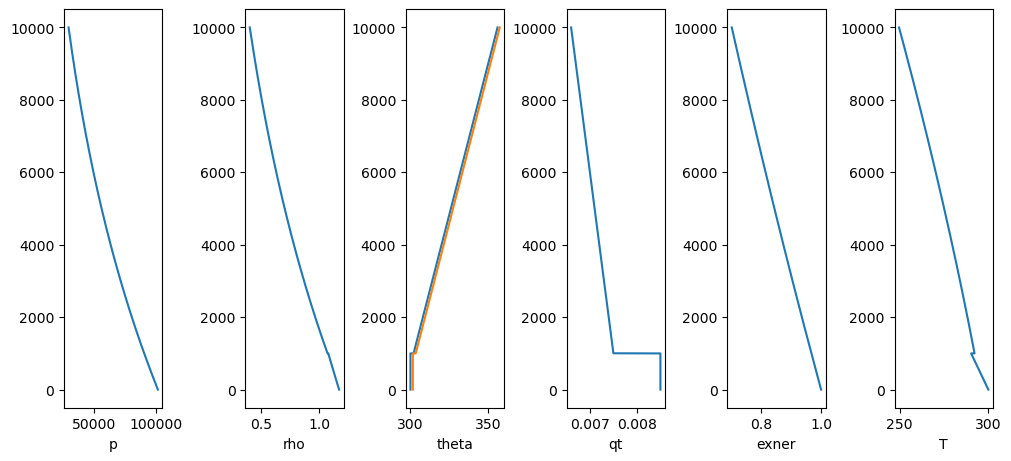

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4.5), constrained_layout=True)
plt.subplot(161)
plt.plot(background.p, background.z)
plt.xlabel("p")
plt.subplot(162)
plt.plot(background.rho, background.z)
plt.xlabel("rho")
plt.subplot(163)
plt.plot(background.theta, background.z)
plt.plot(background.thetav, background.z)
plt.xlabel("theta")
plt.subplot(164)
plt.plot(background.qt, background.z)
plt.xlabel("qt")
plt.subplot(165)
plt.plot(background.exner, background.z)
plt.xlabel("exner")
plt.subplot(166)
plt.plot(background.T, background.z)
plt.xlabel("T")

Text(0.5, 0, 'buoyancy')

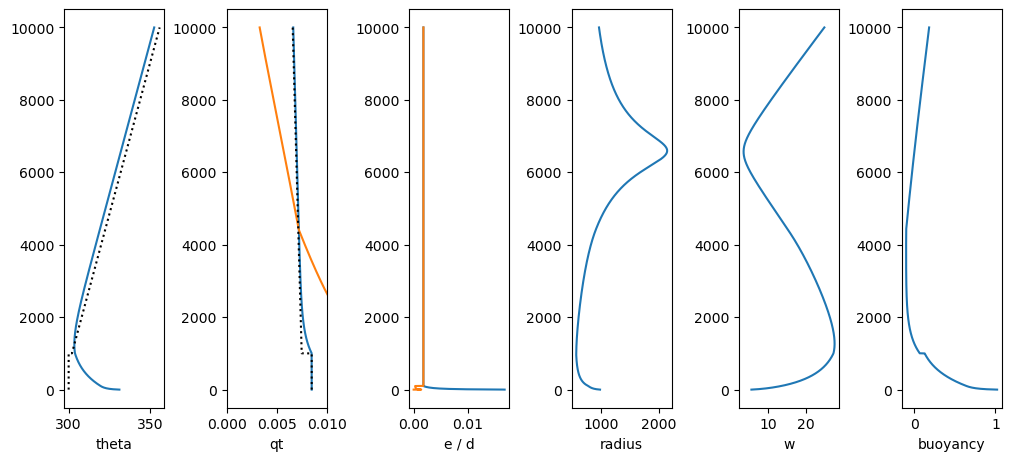

In [6]:
plt.figure(figsize=(10, 4.5), constrained_layout=True)
plt.subplot(161)
plt.plot(plume_t["theta"], plume_t["z"])
plt.plot(background.theta, background.z, "k:")
plt.xlabel("theta")
plt.subplot(162)
plt.plot(plume_t["qt"], plume_t["z"])
plt.plot(plume_t["qsat"], plume_t["z"])
plt.plot(background.qt, background.z, "k:")
plt.xlabel("qt")
plt.xlim(0, 0.01)
plt.subplot(163)
plt.plot(plume_t["e"] / plume_t["m"], plume_t["z"])
plt.plot(plume_t["d"] / plume_t["m"], plume_t["z"])
plt.xlabel("e / d")
plt.subplot(164)
plt.plot((plume_t["area"] / np.pi) ** 0.5, plume_t["z"])
plt.xlabel("radius")
plt.subplot(165)
plt.plot(plume_t["w"], plume_t["z"])
plt.xlabel("w")
plt.subplot(166)
# plt.plot(plume_t["m"], plume_t["z"])
# plt.xlabel('mass flux')
plt.plot(plume_t["b"], plume_t["z"])
plt.xlabel("buoyancy")